# 240520 BDA 멘토링클래스 실습

#### 필요한 Module Import 및 변수 설정

In [1]:
''' 1. Module Import '''
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# Batch_Size, Train_epoch 설정
BATCH_SIZE = 128
TRN_EPOCHS = 10

#### device 설정

In [3]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0+cpu  Device: cpu


#### 데이터셋 다운로드 및 확인

In [3]:
''' 3. CIFAR10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor()) # 이미지를 Tensor 형태로 변환(0~1)

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

NameError: name 'datasets' is not defined

------

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    #train_loader object, which is typically a DataLoader in PyTorch. The DataLoader object loads batches of data from a dataset, where X_train represents the input features and y_train represents the target labels. 
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    #'X_train: prints the size and data type of the input features batch X_train. (X_train의 크기와 데이터 유형을 출력)
    #[batch size, number of channels, height, width]
    #X_train.size(): returns the dimensions of the tensor, (텐서의 차원을 반환)
    #X_train.type():  returns the data type of the tensor.(텐서의 데이터 유형을 반환)
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor


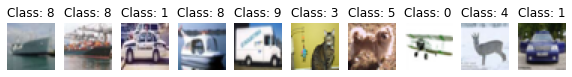

In [7]:
''' 5. 데이터 확인하기 (2) '''
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True' #특정 환경에서 라이브러리 충돌 문제를 해결하기 위한 설정

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

#### 모델 설계
## CNN 모델 Class (1)

In [8]:
''' 6. Convolutional Neural Network(CNN) 모델 설계하기 (1) '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer
        #in_channels = 3: RGB color channels
        #out_channels = 8: numbre of feature map
        #kernel_size = 3: 3 x 3
        #Padding: 1 (to keep the input and output dimensions the same)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        
        # Second convolutional layer
        #Input channels: 8 (the number of output channels from conv1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
       
        # Flatten the feature map to feed into fully connected layers
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        

        # Fully connected layer: input 8*8*16 (== is the size of the flatten feature map), output 64
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        # Fully connected layer: input 64, output 32
        self.fc2 = nn.Linear(64, 32)
        # Fully connected layer: input 32, output 10 ( 10= number of classes, the number of classes for classification)
        self.fc3 = nn.Linear(32, 10)


        
    def forward(self, x):
        # First convolution -> ReLU -> Max pooling
        # Applies the first convolutional layer to the input x
        x = self.conv1(x) # (batch_size, 3, 32, 32) -> (batch_size, 8, 32, 32)
        x = F.relu(x)
        # Max pooling is applied, reducing the spatial dimensions by half.
        x = self.pool(x)  # (batch_size, 8, 32, 32) -> (batch_size, 8, 16, 16)
        
        # Second convolution -> ReLU -> Max pooling
        x = self.conv2(x) # (batch_size, 8, 16, 16) -> (batch_size, 16, 16, 16)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 16, 16, 16) -> (batch_size, 16, 8, 8)

        # Flatten the feature map to feed into fully connected layers
        # The feature maps are flattened from (batch_size, 16, 8, 8) to (batch_size, 1024) to prepare for the fully connected layers.
        x = x.view(-1, 8 * 8 * 16)
        
        # Fully connected layer -> ReLU
        x = self.fc1(x)
        x = F.relu(x)
        
        # Fully connected layer -> ReLU
        x = self.fc2(x)
        x = F.relu(x)

        # Final fully connected layer -> log_softmax
        x = self.fc3(x)
        # F.log_softmax is applied to the output, ensuring it operates along the correct dimension (dim=1), which is the class dimension.
        out = F.log_softmax(x)
        return out

## CNN 모델 Class (2)

In [9]:
''' 7. Convolutional Neural Network(CNN) 모델 설계하기 (2) '''
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.feature_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc_layer = nn.Sequential(
            # The fc_layer consists of three Fully Connected layers with ReLU activations in between.
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        
    def forward(self, x):
        # Pass through the feature extraction layers
        x = self.feature_layer(x)

        x = x.view(-1, 1024)
        
        x = self.fc_layer(x)
        out = F.log_softmax(x)
        return out

In [10]:
# 생성한 모델 확인
model = CNN().to(DEVICE)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


#### Optimizer, Objective Function 설정

In [11]:
''' 8. Optimizer, Objective Function 설정하기 '''
# The Adam optimizer is used to update the model's parameters based on the gradients computed during backpropagation.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# Loss Function: nn.CrossEntropyLoss(This loss function combines nn.LogSoftmax() and nn.NLLLoss() in one single class.)
criterion = nn.CrossEntropyLoss()

#### 모델 학습 및 학습 데이터의 성능 확인하는 `train` 함수 정의

In [12]:
''' 9. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # Set the model to training mode                
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # Move input data to the specified device
        label = label.to(DEVICE) # Move labels to the specified device
        optimizer.zero_grad()           # Zero the gradients for the optimizer(Optimizer의 기울기를 0으로 초기화)
        # Forward pass(순전파)
        output = model(image)
        
        # 역전파 및 옵티마이저 스텝(손실 계산)
        loss = criterion(output, label) # CrossEntropy를 이용해 Loss값 계산
        
        # Backward pass and optimization (역전파 및 옵티마이저 스텝)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

#### 검증 데이터의 성능 확인하는 `evaluate` 함수 정의

In [13]:
''' 10. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()                          # Set the model to evaluation mode (평가 상태로 지정)
    test_loss = 0
    correct = 0                           # Variable to keep track of the number of correct predictions(올바른 Class로 평가했는지 알아보기 위해 임의 변수 설정)

    with torch.no_grad():                 # Disable gradient calculation to save memory and computations(Gradient를 통해 파라미터 값들이 업데이트되는 현상 방지)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)       # Get model predictions
            test_loss += criterion(output, label).item()                     # Accumulate the loss(test_loss값, 즉 현재 배치에 대한 손실을 계산하고 이를 누적합니다.)
            prediction = output.max(1, keepdim = True)[1]                    # Get the index of the max log-probability(두 번째 차원을 따라 최대 값을 갖는 인덱스(즉, 예측 클래스)를 얻습니다.)
            correct += prediction.eq(label.view_as(prediction)).sum().item() # Count correct predictions (예측 클래스와 실제 레이블 클래스 비교하여 올바른 예측 수를 셉니다)
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE) # Calculate the average loss(평균 손실을 계산)
    test_accuracy = 100. * correct / len(test_loader.dataset)   # Calculate the accuracy(정확도를 계산)
    return test_loss, test_accuracy

#### 학습 실행 및 Loss와 Accuracy 확인

In [14]:
''' 11. CNN 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
# 각 에포크(epoch)마다 모델을 훈련시키고 평가하는 과정
for epoch in range(1, TRN_EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 100)   # Execute the defined train function(정의한 train함수 실행)
    test_loss, test_accuracy = evaluate(model, test_loader)     # Calculate the loss and accuracy for each epoch(각 Epoch별로 출력되는 Loss값과 Accuracy 값 계산)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.310983
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.924593
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.771134
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.615945

[EPOCH: 1], 	Test Loss: 1.6214, 	Test Accuracy: 42.34 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.490496
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.412606
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.522511
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.429622

[EPOCH: 2], 	Test Loss: 1.4681, 	Test Accuracy: 46.81 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 1.461622
Train Epoch: 3 [12800/50000 (26%)]	Train Loss: 1.379593
Train Epoch: 3 [25600/50000 (51%)]	Train Loss: 1.415710
Train Epoch: 3 [38400/50000 (77%)]	Train Loss: 1.391008

[EPOCH: 3], 	Test Loss: 1.3721, 	Test Accuracy: 51.23 % 

Train Epoch: 4 [0/50000 (0%)]	Train Loss: 1.454861
Train Epoch: 4 [12800/50000 (26%)]	Train Loss: 1.278789
Train Epoch: 4 [25600/50000 (51%)]	Train Loss: 1.384327
Tra

<span style='color:navy; font-size:18px'>  **Data Augmentation 기법 적용해보며 모델 성능 비교해보기** </span>

> Data Augmentation : https://pytorch.org/vision/stable/transforms.html#geometry

Data Augmentation 적용 전 Accuracy: 61.72%

In [ ]:
'''
# transforms.RandomHorizontalFlip()
# Test Accuracy: 65.12% 
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
'''

In [ ]:
'''
# RandomRotation
# Test Accuracy: 66.04% 
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([transforms.RandomRotation(45),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

'''

In [ ]:
'''
# transforms.RandomResizedCrop
# Test Accuracy: 66.14% 
train_dataset = datasets.CIFAR10(root="../data/CIFAR_10",
                                 train=True,
                                 download=True,
                                 transform=transforms.Compose([transforms.RandomResizedCrop(32, scale=(0.08, 2.0)),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
'''

In [ ]:
'''
#앞에서 실습한 세 기법을 모두 적용
# Test Accuracy: 64.40 %
train_dataset = datasets.CIFAR10(root="../data/CIFAR_10",
                                 train=True, # Specifies that this dataset is for training
                                 download=True, # Download the dataset if it's not already present
                                 transform=transforms.Compose([# Randomly crop the image to 32x32 with a scale from 0.08 to 2.0 of the original size
                                                               transforms.RandomResizedCrop(32, scale=(0.08, 2.0)),
                                                               # Randomly rotate the image up to 45 degrees
                                                               transforms.RandomRotation(45), 
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.ToTensor(),
                                                               # Normalizes the image by setting the mean to 0.5 and standard deviation to 0.5 for each channel (R, G, B). This centers the pixel values around 0 and scales them to have a standard deviation of 1.
                                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
'''